In [1]:
from keras.layers import Input
from keras.models import Model, Sequential
from keras.layers.core import Reshape, Dense, Dropout, Flatten
from keras.layers import Embedding, multiply, BatchNormalization
from keras.datasets import mnist
import numpy as np
%matplotlib inline
# 我們會使用到一些內建的資料庫, MAC需要加入以下兩行, 才不會把對方的ssl憑證視為無效
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

Using TensorFlow backend.


In [2]:
img_shape = (28, 28)
random_dim = 100

In [3]:
# 回傳值: ((訓練特徵, 訓練目標), (測試特徵, 測試目標))
(x_train, y_train),(x_test, y_test) = mnist.load_data()

In [4]:
x_train.shape

(60000, 28, 28)

In [5]:
from keras.utils import np_utils
# reshape讓他從 32 * 32變成 784 * 1的一維陣列
# 讓我們標準化到-1~1區間
x_train_shaped = (x_train.astype("float32") - 127.5)/127.5
x_test_shaped = (x_test.astype("float32") - 127.5)/127.5
y_train = y_train.reshape(-1, 1)

In [6]:
generator = Sequential()
generator.add(Dense(256, input_dim=random_dim, 
                    activation='relu', 
                    kernel_initializer="random_normal"))
generator.add(BatchNormalization())
generator.add(Dense(512, activation='relu', 
                    kernel_initializer="random_normal"))
generator.add(BatchNormalization())
generator.add(Dense(784, activation='tanh'))
generator.add(Reshape(img_shape))
generator.summary()

noise = Input(shape=(random_dim,))
label = Input(shape=(1,), dtype='int32')
label_embedding = Flatten()(Embedding(input_dim = 10, output_dim = random_dim)(label))

model_input = multiply([noise, label_embedding])
img = generator(model_input)

cgenerator = Model([noise, label], img)

cgenerator.compile(loss='binary_crossentropy', optimizer="adam")
cgenerator.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dense_3 (Dense)              (None, 784)               402192    
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28)            0         
Total params: 562,704
Trainable params: 561,168
Non-trainable params: 1,536
_________________________________________________________________


In [7]:
discriminator = Sequential()
discriminator.add(Dense(512, input_dim=784,
                        activation='relu', 
                        kernel_initializer="random_normal"))
discriminator.add(Dropout(0.25))
discriminator.add(Dense(256, activation='relu',
                        kernel_initializer="random_normal"))
discriminator.add(Dropout(0.25))
discriminator.add(Dense(128, activation='relu',
                        kernel_initializer="random_normal"))
discriminator.add(Dropout(0.25))
discriminator.add(Dense(1, activation='sigmoid'))
discriminator.summary()

img = Input(shape=img_shape)
label = Input(shape=(1,), dtype='int32')
label_embedding = Flatten()(Embedding(10, 784)(label))
flat_img = Flatten()(img)
model_input = multiply([flat_img, label_embedding])
validity = discriminator(model_input)
cdiscriminator = Model([img, label], validity)
cdiscriminator.compile(loss='binary_crossentropy', optimizer="adam")
cdiscriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total para

In [8]:
cdiscriminator.trainable = False
cgan_input = Input(shape=(random_dim,))
cgan_label = Input(shape=(1, ))
x = cgenerator([cgan_input, cgan_label])
cgan_output = cdiscriminator([x, cgan_label])
cgan = Model(inputs=[cgan_input, cgan_label], outputs=cgan_output)
cgan.compile(loss='binary_crossentropy', optimizer="adam")
cgan.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
model_1 (Model)                 (None, 28, 28)       563704      input_5[0][0]                    
                                                                 input_6[0][0]                    
__________________________________________________________________________________________________
model_2 (Model)                 (None, 1)            574113      model_1[1][0]                    
          

In [9]:
batch_size = 200
epoch_count = 30
d_loss_list = []
g_loss_list = []
for epoch in range(0, epoch_count):
    for batch_count in range(0, 300):
        idx = np.random.randint(0, x_train.shape[0], batch_size)
        imgs = x_train_shaped[idx]
        labels = y_train[idx]
        
        valid = np.ones((batch_size, 1))
        fake = np.zeros((batch_size, 1))
        # 步驟0:讓創作家製造出fake image
        noise = np.random.normal(0, 1, (batch_size, random_dim))
        gen_imgs = cgenerator.predict([noise, labels])

        cdiscriminator.trainable = True
        # 步驟1:讓鑑賞家鑑賞對的image
        d_loss_real = cdiscriminator.train_on_batch([imgs, labels], valid)
        # 步驟2:讓鑑賞家鑑賞錯的image
        d_loss_fake = cdiscriminator.train_on_batch([gen_imgs, labels], fake)
        d_loss = (d_loss_real + d_loss_fake) / 2

        cdiscriminator.trainable = False
        noise = np.random.normal(0, 1, (batch_size, random_dim))
        # 步驟3:訓練創作家的創作能力
        g_loss = cgan.train_on_batch([noise, labels], valid)
    dash = "-" * 15
    print(dash, "epoch", epoch, dash)
    print("Discriminator loss:", d_loss)
    print("Generator loss:", g_loss)
    d_loss_list.append(d_loss)
    g_loss_list.append(g_loss)


--------------- epoch 0 ---------------
Discriminator loss: 0.04729007929563522
Generator loss: 0.585347
--------------- epoch 1 ---------------
Discriminator loss: 0.0043478356674313545
Generator loss: 2.9857557
--------------- epoch 2 ---------------
Discriminator loss: 0.025714386254549026
Generator loss: 4.988716
--------------- epoch 3 ---------------
Discriminator loss: 0.02358744852244854
Generator loss: 0.3187806
--------------- epoch 4 ---------------
Discriminator loss: 0.018145833164453506
Generator loss: 6.3042507
--------------- epoch 5 ---------------
Discriminator loss: 0.018201807513833046
Generator loss: 1.0470262
--------------- epoch 6 ---------------
Discriminator loss: 0.005387197248637676
Generator loss: 1.4840078
--------------- epoch 7 ---------------
Discriminator loss: 0.07645069062709808
Generator loss: 4.592291
--------------- epoch 8 ---------------
Discriminator loss: 0.057617343962192535
Generator loss: 2.772187
--------------- epoch 9 ---------------
Dis

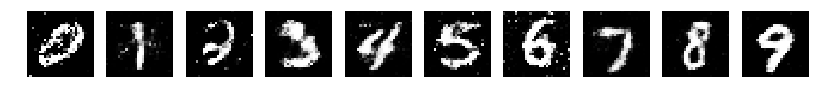

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
noise = np.random.normal(0, 1, (10, random_dim))
sampled_labels = np.arange(0, 10).reshape(-1, 1)

gen_imgs = cgenerator.predict([noise, sampled_labels])

# Rescale images 0 - 1
gen_imgs = 0.5 * gen_imgs + 0.5
gen_imgs = gen_imgs.reshape(10, 28, 28)
plt.figure(figsize = (14, 14))
for i in range(0, 10):
    plt.subplot(1, 10, i + 1)
    plt.axis("off")
    plt.imshow(gen_imgs[i], cmap='gray')
